# Rayleigh drag
Display closeup of Rayleigh drag (if any).

Based on `/home/156/aek156/notebooks/github/aekiss/notebooks/bathymetry-closeup-KaraStr-Rayleighdamping.ipynb` https://github.com/aekiss/notebooks/blob/master/bathymetry-closeup-KaraStr-Rayleighdamping.ipynb

In [1]:
# Eliminate margins
# from https://stackoverflow.com/questions/44298864/how-can-i-eliminate-the-gray-border-around-jupyter-ipython-notebooks-in-my-brows
from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:97% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

In [2]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import xarray as xr
from matplotlib import cm
import netCDF4 as nc
import IPython.display
import regex as re
import glob
import copy
import re

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [15]:
ft_data['1deg']['field_table']

'/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1/output059/ocean/field_table'

In [14]:
# load Rayleigh drag data from final field_table of each run
ft_data = copy.deepcopy(exptdata.exptdict)  # to store fields under the same keys as exptdata.exptdict
for ekey in ft_data.keys():
    ftde = ft_data[ekey]
    ftfiles = glob.glob(os.path.join(ftde['exptdir'], 'output*/ocean/field_table'))
    ftfiles.sort()
    ftfile = ftfiles[-1]
    gridfile = xr.open_dataset(os.path.join(os.path.dirname(ftfile),'ocean_grid.nc'))
#     ftde['xu_ocean'] = gridfile.xu_ocean.values
#     ftde['yu_ocean'] = gridfile.yu_ocean.values
    ftde['geolon_c'] = gridfile.geolon_c #.values
    ftde['geolat_c'] = gridfile.geolat_c #.values
    ftde['kmu'] = gridfile.kmu #.values

    ftde['field_table'] = ftfile
    damp_table = ''
    with open(ftfile,"r") as f:
        for line in f:
            if line.startswith('"rayleigh_damp_table"'):
                break
        for line in f:
            if line.startswith('"rayleigh"'):
                damp_table += line
            else:
                break
    ftde['damp_table_ii'] = [ int(i)-1 for i in re.findall('itable=(\d+)', damp_table) ]  # subtract 1 to index from 0
    ftde['damp_table_jj'] = [ int(j)-1 for j in re.findall('jtable=(\d+)', damp_table) ]  # subtract 1 to index from 0
    ftde['damp_time'] = [ int(j) for j in re.findall('rayleigh_damp_table=(\d+)', damp_table) ]
    # make damp time map; use kmu to get land mask
    dtm = ftde['kmu'].where(np.isnan(ftde['kmu']), 0)  # zero out ocean points
    for i, j, dt in zip(ftde['damp_table_ii'], ftde['damp_table_jj'], ftde['damp_time']):
        dtm[j][i] = dt  # put damp_time value in at every point that has damping
    ftde['damp_time_map'] = dtm

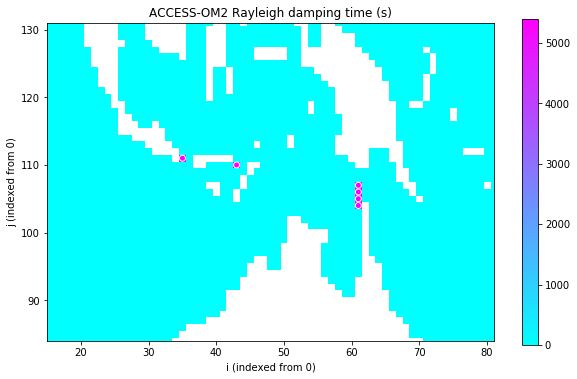

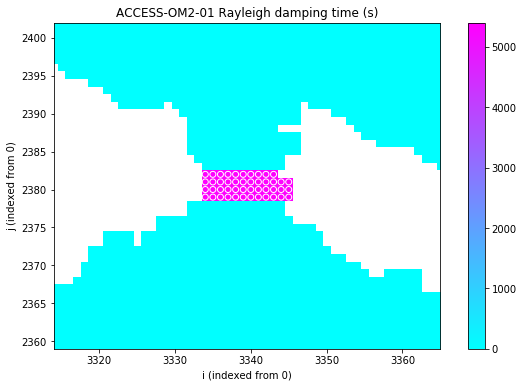

In [11]:
# make images
margin = 20  # grid cells
for ekey in ft_data.keys():
    ftde = ft_data[ekey]
    if len(ftde['damp_time']) > 0:
        imin = min(ftde['damp_table_ii']) - margin
        imax = max(ftde['damp_table_ii']) + margin
        jmin = min(ftde['damp_table_jj']) - margin
        jmax = max(ftde['damp_table_jj']) + margin
        plt.figure(figsize=(10,6))
        plt.imshow(ftde['damp_time_map'], origin='lower', cmap=plt.get_cmap('cool'))
        plt.colorbar()
        plt.scatter(ftde['damp_table_ii'],ftde['damp_table_jj'], facecolors='none', edgecolors='w')
        plt.xlim(imin,imax)
        plt.ylim(jmin,jmax)
        plt.title(ftde['desc']+' Rayleigh damping time (s)')
        plt.xlabel('i (indexed from 0)')
        plt.ylabel('j (indexed from 0)')

In [ ]:
STOPHERE

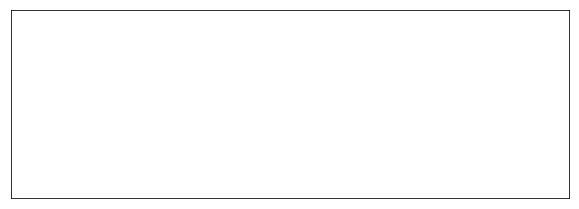

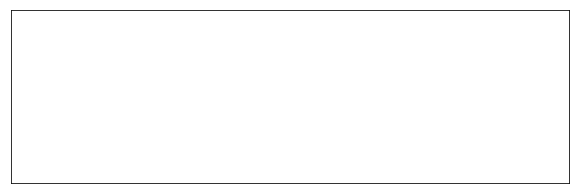

In [151]:
# make plots in geographic coordinates - UNFINISHED!
margin = 5  # degrees
for ekey in ft_data.keys():
    ftde = ft_data[ekey]
    if len(ftde['damp_time']) > 0:
# #         print(ekey)
#         imin = min(ftde['damp_table_ii']) - margin
#         imax = max(ftde['damp_table_ii']) + margin
#         jmin = min(ftde['damp_table_jj']) - margin
#         jmax = max(ftde['damp_table_jj']) + margin
# #         print(imin, imax, jmin, jmax)
# #         ft_data['1deg']['kmu'].isel(xu_ocean=slice(imin,imax)).isel(yu_ocean=slice(jmin,jmax)).plot()
# #         lons = ftde['geolon_c'].isel(xu_ocean=ftde['damp_table_ii']).isel(yu_ocean=ftde['damp_table_jj'])
# #         lats = ftde['geolat_c'].isel(xu_ocean=ftde['damp_table_ii']).isel(yu_ocean=ftde['damp_table_jj'])


        lons = ftde['geolon_c'].isel(xu_ocean=ftde['damp_table_ii']).isel(yu_ocean=ftde['damp_table_jj'])
        lats = ftde['geolat_c'].isel(xu_ocean=ftde['damp_table_ii']).isel(yu_ocean=ftde['damp_table_jj'])

        plt.figure(figsize=(10,10))
        m = Basemap(projection='cea',
                    llcrnrlat=lats.min().values.tolist()-margin,
                    urcrnrlat=lats.max().values.tolist()+margin,
                    llcrnrlon=lons.min().values.tolist()-margin,
                    urcrnrlon=lons.max().values.tolist()+margin,
                    resolution='l')
        x, y = m(*(ftde['geolon_c'].data, ftde['geolon_c'].data))
#         m.drawcoastlines()
#         m.fillcontinents(color='coral',lake_color='aqua')
        cs = m.contour(x,y,ftde['kmu'], [0, 5, 50])


#         break


#         plt.figure(figsize=(10,10))
#         ft_data['1deg']['kmu'].plot()
# #         plt.xlim(ftde['geolon_c'][jmin][imin]-10, ftde['geolon_c'][jmax][imax]+10)
# #         plt.ylim(ftde['geolat_c'][jmin][imin]-10, ftde['geolat_c'][jmax][imax]+10)

#         plt.xlim(lons.min().values.tolist()-margin, lons.max().values.tolist()+margin)

#         plt.ylim(lats.min().values.tolist()-margin, lats.max().values.tolist()+margin)

# #         plt.ylim(ftde['geolat_c'][jmin][imin]-10, ftde['geolat_c'][jmax][imax]+10)

        
#         break

#         plt.ylim(jmin,jmax)



